In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import snmfem.conf as conf
import json
import numpy as np
from pathlib import Path
import re
import snmfem.estimators as estimators
import snmfem.measures as measures
from sklearn.decomposition import NMF as sk_NMF
import warnings
import matplotlib.pyplot as plt

# NMF function

In [4]:
def run_snmfem_NMF(Xflat,true_spectra, true_maps,G, dict,skip_G = False,force_simplex = True, mu =0, epsilon_reg = 1.0, get_ind = False, u = False,**kwargs) : 
    # Load estimator
    Estimator = getattr(estimators, "NMF") 

    estimator = Estimator(**dict,force_simplex=force_simplex,mu=mu,epsilon_reg=epsilon_reg)
    if skip_G : 
        estimator.fit(Xflat)
    else : 
        estimator.fit(Xflat,G=G)
    G = estimator.G_
    P = estimator.P_
    A = estimator.A_
    angle = measures.find_min_angle(true_spectra,(G@P).T, get_ind, unique=u)
    mse = measures.find_min_MSE(true_maps,A, get_ind, unique=u)
    return angle, mse, (G@P), A

def run_snmfem_SmoothNMF(Xflat,true_spectra, true_maps,G, dict, shape_2D,skip_G = False,force_simplex = True, mu =0, epsilon_reg = 1.0, get_ind = False,lambda_L=0.0, u = False,**kwargs) : 
    # Load estimator
    Estimator = getattr(estimators, "SmoothNMF") 

    estimator = Estimator(**dict,shape_2d=shape_2D,lambda_L=lambda_L,force_simplex=force_simplex,mu=mu,epsilon_reg=epsilon_reg)
    if skip_G : 
        estimator.fit(Xflat)
    else : 
        estimator.fit(Xflat,G=G)
    G = estimator.G_
    P = estimator.P_
    A = estimator.A_
    angle = measures.find_min_angle(true_spectra,(G@P).T, get_ind, unique = u)
    mse = measures.find_min_MSE(true_maps,A, get_ind, unique=u)
    return angle, mse, (G@P), A

def run_scikit_NMF(Xflat,true_spectra, true_maps, G,dict,loss = "frobenius",alpha = 0.0, l1_ratio = 1.0, regularization = "components", get_ind = False, u = False,**kwargs) :
    G = None
    estimator = sk_NMF(**dict,beta_loss=loss, alpha = alpha, l1_ratio = l1_ratio, regularization = regularization,solver="mu")

    W = estimator.fit_transform(Xflat)
    H = estimator.components_
    W, H = rescaled_DA(W,H)
    angle = measures.find_min_angle(true_spectra,W.T, get_ind, unique = u)
    mse = measures.find_min_MSE(true_maps,H, get_ind, unique=u)
    return angle, mse, W, H

def load_data(sample) : 
    data = np.load(sample)
    X = data["X"]
    nx, ny, ns = X.shape
    Xflat = X.transpose([2,0,1]).reshape(ns, nx*ny)
    densities = data["densities"]
    phases = data["phases"]
    true_spectra_flat = np.expand_dims(densities, axis=1) * phases * data["N"]
    true_maps = data["weights"]
    k = true_maps.shape[2]
    true_maps_flat = true_maps.transpose([2,0,1]).reshape(k,nx*ny)
    G = data["G"]
    return Xflat, true_spectra_flat, true_maps_flat, G

def rescaled_DA(D,A) : 
    k, p = A.shape
    o = np.ones((p,))
    s = np.linalg.lstsq(A.T, o)[0]
    D_rescale = D@np.diag(1/s)
    A_rescale = np.diag(s)@A
    return D_rescale, A_rescale

# Running NMF

## Inputs

In [5]:
data_json = conf.SCRIPT_CONFIG_PATH / Path("dataset_EDXS_small.json")
with open(data_json,"r") as f :
    data_dict = json.load(f)

num_list = [1,2,3]
data_folder = conf.DATASETS_PATH / Path(data_dict["data_folder"])
samples = [data_folder / Path("sample_{}.npz".format(i)) for i in num_list ]


In [6]:
default_params = {
    "n_components" : data_dict["model_parameters"]["params_dict"]["k"],
    "tol" : 1e-4,
    "max_iter" : 10000,
    "init" : "nndsvda",
    "random_state" : 1,
    "verbose" : 0
}
params_dict = {
    "force_simplex" : True,
    "skip_G" : False,
    "lambda_L" : 10.0,
    "u" : True,
    "shape_2D" : data_dict["weights_parameters"]["shape_2D"]
}
Func_map = {
    "snmfem" : (run_snmfem_NMF,None),
    "smooth_snmfem 1" : (run_snmfem_SmoothNMF,{"lambda_L" : 1.0}), 
    "smooth_snmfem 10" : (run_snmfem_SmoothNMF,{"lambda_L" : 10.0}), 
    "scikit_KL" : (run_scikit_NMF,{"loss" : "kullback-leibler"})
    }

In [21]:
%matplotlib agg
warnings.simplefilter(action='ignore', category=FutureWarning)
sentences = []
titles = []
chosen_one = 0
k = data_dict["model_parameters"]["params_dict"]["k"]
spectra_fig, spectra_axes = plt.subplots(len(Func_map.keys()),k,figsize = (100,100))
maps_fig, maps_axes = plt.subplots(len(Func_map.keys())+1,k,figsize = (100,100))
fontsize = 30

for j,s in enumerate(samples) : 
    Xflat, true_spectra, true_maps, G = load_data(s)
    result_angles = np.zeros((len(Func_map.keys()),k))
    result_mse = np.zeros((len(Func_map.keys()),k))
    
    if j == chosen_one : 
        for i, key in enumerate(Func_map.keys()) : 
            dict_copy = params_dict.copy()
            dict_copy.update({"get_ind" : True})
            if not(Func_map[key][1] is None) :           
                dict_copy.update(Func_map[key][1])
                titles.append("{} with {}".format(key,Func_map[key][1]).ljust(50))
            else : 
                titles.append("{}".format(key).ljust(50))
            estim = Func_map[key][0](Xflat,true_spectra,true_maps,G,default_params,**dict_copy) 
            for p in range(k) : 
                spectra_axes[i,p].plot(true_spectra[p],'bo',label='truth',linewidth=4)
                spectra_axes[i,p].plot(estim[2][:,estim[0][p]],'r-',label='reconstructed',markersize=3.5)
                maps_axes[i,p].imshow(estim[3][estim[0][p]].reshape(params_dict["shape_2D"][0],params_dict["shape_2D"][1]))
                maps_axes[-1,p].imshow(true_maps[p].reshape(params_dict["shape_2D"][0],params_dict["shape_2D"][1]))
                # maps_axes[i,p].colorbar()
            maps_axes[i,0].set_title(key,fontsize = fontsize)
            maps_axes[-1,0].set_title("Ground Truth",fontsize=fontsize)
            spectra_axes[i,0].set_title(key,fontsize = fontsize)
            spectra_axes[i,0].legend(fontsize = fontsize)
    else : 
        for i, key in enumerate(Func_map.keys()) : 
            if not(Func_map[key][1] is None) :           
                params_dict.update(Func_map[key][1])
                sentences.append("{} with {}".format(key,Func_map[key][1]).ljust(50))
            else : 
                sentences.append("{}".format(key).ljust(50))
            estim = Func_map[key][0](Xflat,true_spectra,true_maps,G,default_params,**params_dict) 
            result_angles[i,:] += np.array(estim[0])
            result_mse[i,:] += np.array(estim[1])

result_angles /= len(samples)
result_mse /= len(samples)


/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/snmfem/estimators/base.py:107: RuntimeWarning: invalid value encountered in double_scalars
  elif abs((eval_before - eval_after)/eval_before) < self.tol:
exits because of relative change < tol: 9.398351046544208e-05
Stopped after 7 iterations in 0.0 minutes and 0.0 seconds.
/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/snmfem/estimators/base.py:107: RuntimeWarning: invalid value encountered in double_scalars
  elif abs((eval_before - eval_after)/eval_before) < self.tol:
exits because of relative change < tol: 8.983152826943207e-05
Stopped after 7 iterations in 0.0 minutes and 0.0 seconds.
/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/snmfem/estimators/base.py:107: RuntimeWarning: invalid value encountered in double_scalars
  elif abs((eval_before - eval_after)/eval_before) < self.tol:
exits because of relative change < tol: 9.535500011583385e-05
Stopped after 12 iterations in 0.0 minutes and 0.0 seconds.
/mnt/c/Users/teurtrie/Travail/SNMF_EDXS/snmfem/estimat

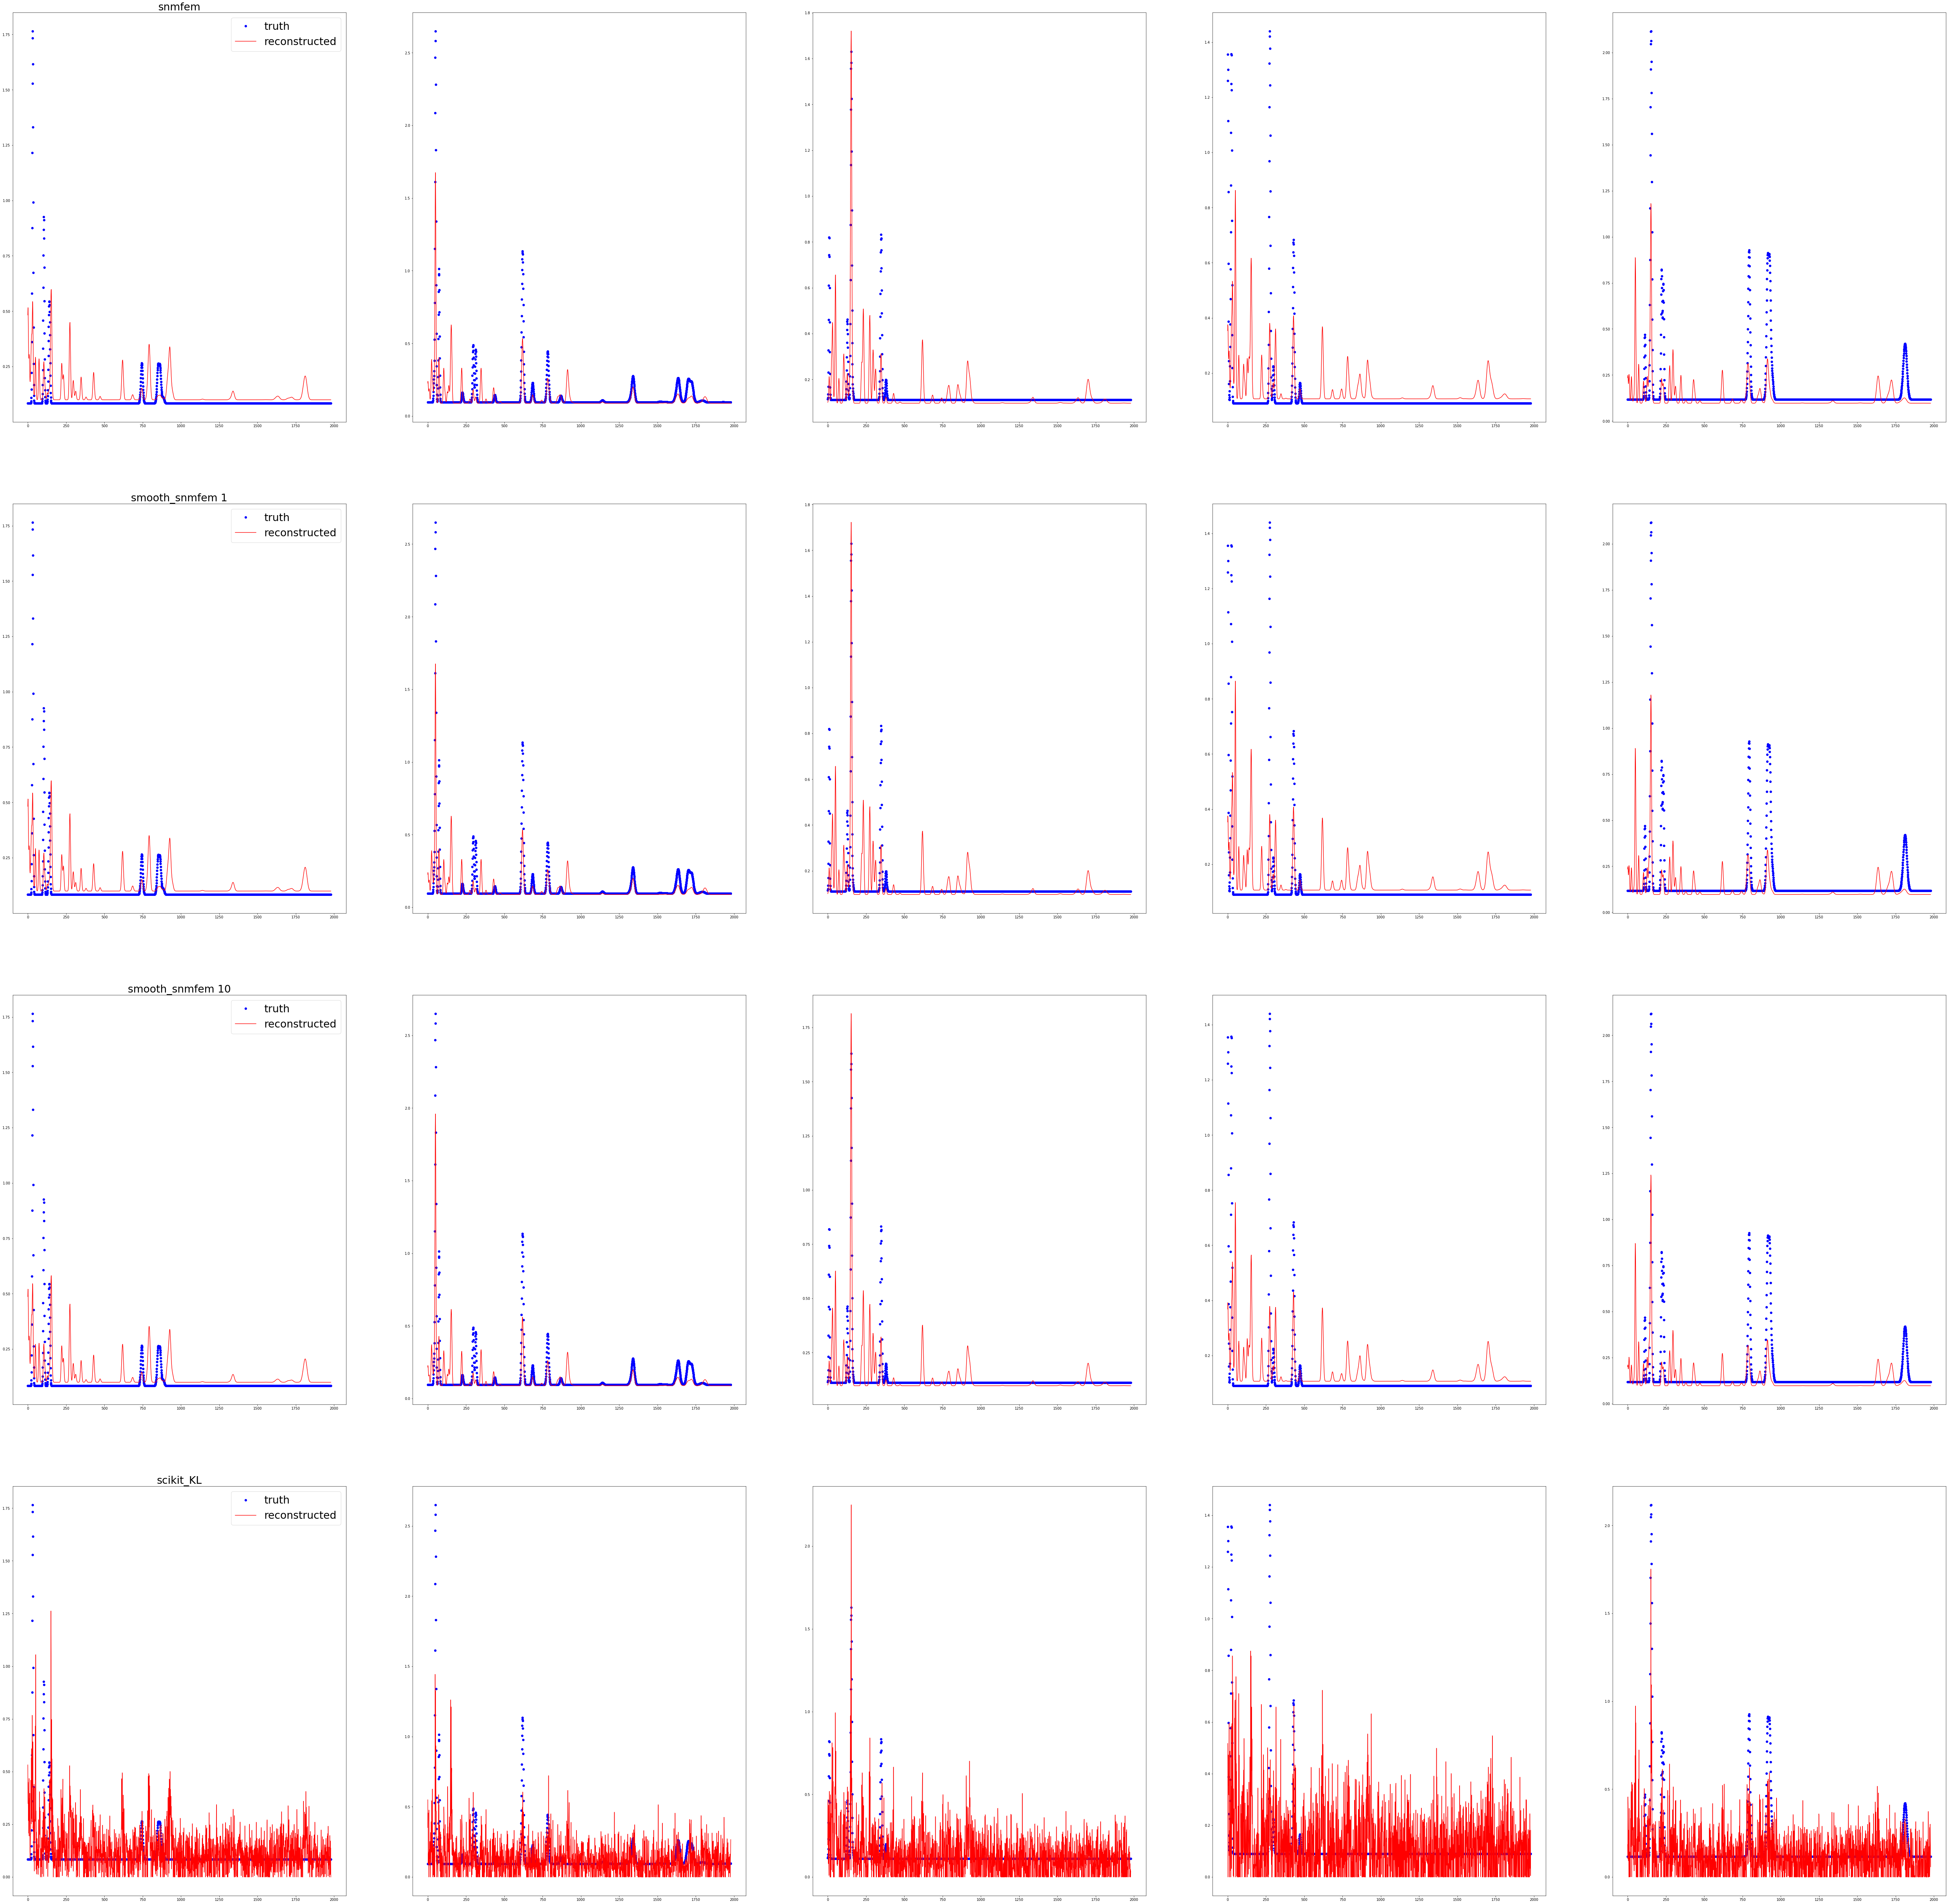

In [23]:
%matplotlib inline
spectra_fig

In [ ]:
%matplotlib inline
maps_fig

## Printing statistics

In [24]:
print("AVERAGE ANGLES")
print(50*"-")
for i, line in enumerate(result_angles) : 
    print("{} : {}".format(sentences[i],line))

print(150*"=")
print("AVERAGE MSE")
print(50*"-")
for i, line in enumerate(result_mse) : 
    print("{} : {}".format(sentences[i],line))


AVERAGE ANGLES
--------------------------------------------------
snmfem                                             : [14.58047312 12.69234438 10.15546864 13.26306616 12.97088056]
smooth_snmfem 1 with {'lambda_L': 1.0}             : [14.59662868 12.62017394  9.93683814 13.36111773  9.60715157]
smooth_snmfem 10 with {'lambda_L': 10.0}           : [14.4295947  12.80643071 10.20533251 12.96919616 13.006624  ]
scikit_KL with {'loss': 'kullback-leibler'}        : [17.60787341 18.00068891 15.25342608 18.65520397 16.37661066]
AVERAGE MSE
--------------------------------------------------
snmfem                                             : [ 1.23963985  1.37399282  1.28091278  1.34920318 10.03521518]
smooth_snmfem 1 with {'lambda_L': 1.0}             : [1.21084892 1.35448489 1.24794585 1.32403828 9.99851934]
smooth_snmfem 10 with {'lambda_L': 10.0}           : [1.05899363 1.21154485 1.10036748 1.18432731 9.96122846]
scikit_KL with {'loss': 'kullback-leibler'}        : [4.34362594 4.39838448 

# Plotting results

# NMF for one sample

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

force_simplex = True
skip_G = False
alpha = 1.0
index = 2
lambda_L = 10.0
nx,ny = data_dict["weights_parameters"]["shape_2D"]
shape_2D = nx,ny
k = default_params["n_components"]
Xflat, true_spectra, true_maps, G = load_data(samples[index])
snmfem = run_snmfem_NMF(Xflat, true_spectra, true_maps, G,default_params,force_simplex=force_simplex,skip_G = skip_G,get_ind=True)
smooth_snmfem = run_snmfem_SmoothNMF(Xflat, true_spectra, true_maps, G,default_params,force_simplex=force_simplex,skip_G = skip_G,get_ind=True,lambda_L=lambda_L,shape_2D = shape_2D)
scikit_KL = run_scikit_NMF(Xflat, true_spectra, true_maps, G,default_params,loss= "kullback-leibler",get_ind = True)
scikit_Fro = run_scikit_NMF(Xflat, true_spectra, true_maps, G,default_params, loss = "frobenius", get_ind = True)
scikit_alpha = run_scikit_NMF(Xflat, true_spectra, true_maps, G,default_params,loss="kullback-leibler",alpha = alpha,get_ind= True)

## Spectra visualisation

In [ ]:
for true_ind in range(5) : 
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(50, 12))
    plt.subplot(151)
    plt.title("SNMFEM")
    plt.plot(true_spectra[true_ind],'bo',label='truth',linewidth=4)
    plt.plot( snmfem[2][:,snmfem[0][true_ind]],'r-',label='reconstructed',markersize=3.5)
    # plt.legend(loc='best')
    plt.xlabel("Energy")
    plt.ylabel("Intensity")

    plt.subplot(152)
    plt.title("Scikit_KL")
    plt.plot(true_spectra[true_ind],'bo',label='truth',linewidth=4)
    plt.plot( scikit_KL[2][:,scikit_KL[0][true_ind]],'r-',label='reconstructed',markersize=3.5)
    # plt.legend(loc='best')
    plt.xlabel("Energy")
    # plt.ylabel("Intensity")

    plt.subplot(153)
    plt.title("SNMFEM SMOOTH")
    plt.plot(true_spectra[true_ind],'bo',label='truth',linewidth=4)
    plt.plot( smooth_snmfem[2][:,smooth_snmfem[0][true_ind]],'r-',label='reconstructed',markersize=3.5)
    # plt.legend(loc='best')
    plt.xlabel("Energy")
    # plt.ylabel("Intensity")

    plt.subplot(154)
    plt.title("Scikit_Fro")
    plt.plot(true_spectra[true_ind],'bo',label='truth',linewidth=4)
    plt.plot( scikit_Fro[2][:,scikit_Fro[0][true_ind]],'r-',label='reconstructed',markersize=3.5)
    plt.legend(loc='best')
    plt.xlabel("Energy")
    # plt.ylabel("Intensity")

    plt.subplot(155)
    plt.title("Scikit_alpha")
    plt.plot(true_spectra[true_ind],'bo',label='truth',linewidth=4)
    plt.plot( scikit_alpha[2][:,scikit_alpha[0][true_ind]],'r-',label='reconstructed',markersize=3.5)
    # plt.legend(loc='best')
    plt.xlabel("Energy")
    # plt.ylabel("Intensity")


    # fig1.tight_layout()

## Maps visualisation

In [ ]:
for true_ind in range(5) :
    plt.rcParams.update({'font.size': 22})
    fig1 = plt.figure(figsize=(50, 12))
    plt.subplot(161)

    plt.imshow(snmfem[3][snmfem[0][true_ind]].reshape(nx,ny), cmap="viridis")
    plt.grid(b=30)
    plt.title("SNMFEM")
    plt.colorbar()

    plt.subplot(162)

    plt.imshow(scikit_KL[3][scikit_KL[0][true_ind]].reshape(nx,ny), cmap="viridis")
    plt.grid(b=30)
    plt.title("Scikit_KL")
    plt.colorbar()

    plt.subplot(163)

    plt.imshow(smooth_snmfem[3][smooth_snmfem[0][true_ind]].reshape(nx,ny), cmap="viridis")
    plt.grid(b=30)
    plt.title("SMOOTH SNMFEM")
    plt.colorbar()

    plt.subplot(164)

    plt.imshow(scikit_Fro[3][scikit_Fro[0][true_ind]].reshape(nx,ny), cmap="viridis")
    plt.grid(b=30)
    plt.title("Scikit_Fro")
    plt.colorbar()

    plt.subplot(165)

    plt.imshow(scikit_alpha[3][scikit_alpha[0][true_ind]].reshape(nx,ny), cmap="viridis")
    plt.grid(b=30)
    plt.title("Scikit_alpha")
    plt.colorbar()
    #plt.clim(0, 1)

    plt.subplot(166)

    plt.imshow(true_maps[true_ind].reshape(nx,ny), cmap="viridis")
    plt.grid(b=30)
    plt.title("Truth")
    plt.colorbar()

In [ ]:
true_maps.shape